In [1]:
# Initial imports
import os
import requests
import pandas as pd
import time
import datetime
import holoviews as hv
from panel.interact import interact
import plotly.express as px
import panel as pn


pn.extension('plotly')

import hvplot.pandas
import numpy as np
from pathlib import Path
from pycoingecko import CoinGeckoAPI
%matplotlib inline

cg = CoinGeckoAPI()


## Initialize some dictionary and lists
portfolio_dict={}  # portfolio dictionary init
portfolio_list=[]  # list of portfolio tickers init
social_dict={} # dictionary for social data init

#choose tickers
portfolio_list = ['bitcoin', 'ethereum', 'chainlink', 'polkadot', 'tellor']


def get_crypto_portfolio_data(data):
### Uses get_price from the sdk and returns data for the users portfolio
    data = cg.get_price(ids=data,vs_currencies='usd', include_market_cap='true', include_24hr_vol='true', include_24hr_change='true', include_last_updated_at='false')
    return data


def get_coin_by_id(data):
### returns information about the coin including social data
    data = cg.get_coin_by_id(id=data,localization='false',tickers='false',market_data='false')
    return data


def create_crypto_portfolio_df(ticker_list):
##returns a portfolio dataframe of from a list of tickers
    #iterate through the list that was passed 
    for ticker in ticker_list:
        
        #get the data from the api
        api_data=get_crypto_portfolio_data(ticker)
    
        #the coin name is the first key in the api return data. We need it.
        coin = list(api_data.keys())[0] 

        #add data to dictionary
        portfolio_dict[coin] = api_data[coin]

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(portfolio_dict, orient='index')
  

    #wrangle the data into a portfolio
    df.columns=['Price', 'Market Cap', '24h Volume', '24h Change']
    df['Market Cap'] = df['Market Cap'].astype('int64')
    #df['24h Volume '] = df['24h Volume '].astype('int32')
    df['24h Change'] = df['24h Change'].astype('float64').round(decimals=2)

    #return the dataframe
    return df

def create_equities_portfolio_df(file="./data/data_equities_portfolio.csv"):
    equities_df=pd.read_csv(file, index_col = 0)
    return equities_df
    

def get_social_df(tickers):
# accepts a list of tickers and returns social inco in a dataframe
    for ticker in tickers:
        data=get_coin_by_id(ticker)
        social_dict[data['id']] = data['community_data']

    #Turn the dict into a data frame.
    df = pd.DataFrame.from_dict(social_dict, orient='index')
    df.columns=['FB Likes', 'TWTR Follows', 'reddit posts 48h', 'reddit comments 48h','reddit subscribes 48h','reddit active 48h','telegram users']
        
    #return the dataframe
    return df

def get_portfolio():
    df1=create_equities_portfolio_df()
    df2=create_crypto_portfolio_df(portfolio_list)   
    df = pd.concat([df1,df2], axis=0, join='inner')
    #df = df.dropna()
    df['Market Cap'] = df['Market Cap'].astype('float64')
    df['24h Change'] = df['24h Change'].astype('float64').round(decimals=2)
    return df
    

def get_crypt_history(ticker_list, start_date = None, end_date = None):
    
    unix_start_date = int(time.mktime(start_date.timetuple()))
    unix_end_date = int(time.mktime(end_date.timetuple()))
    
    history_dfs = []

    for ticker in ticker_list:
        
        #Get the 5 year history 
        history = cg.get_coin_market_chart_range_by_id(id = ticker, vs_currency ='usd', from_timestamp=unix_start_date, to_timestamp=unix_end_date)  
        
        #wrangle the data
        prices = history['prices']
        market_caps = history['market_caps']
        total_volumes = history['total_volumes']
        
        #create the dataframes
        prices_df = pd.DataFrame(prices).set_index(0)
        market_caps_df = pd.DataFrame(market_caps).set_index(0)
        total_volumes_df = pd.DataFrame(total_volumes).set_index(0)
        
        #concat the dataframes
        joined = pd.concat([prices_df,market_caps_df,total_volumes_df], axis = 1, join = 'inner').reset_index()
        joined.columns = ['Date', 'Price', 'Market Caps', 'Total Volumes']
        joined['Date'] = pd.to_datetime(joined['Date'], unit = 'ms')
        joined.insert(loc=0, column='Ticker', value=ticker)
        history_dfs.append(joined)
    history_df=pd.concat(history_dfs)


    #return the 5 yr hostry dataframe
    return history_df

def get_equities_df():
    data_df=pd.read_csv('data/diverse.csv',infer_datetime_format=True, parse_dates = True, index_col = "Date")
    data_df.drop(['Date.1','Date.2'],axis=1, inplace=True)
    data_df.rename(columns={'Close':'S&P','Close.1':'Gold','Close.2':'20Yr'},inplace=True)
    return data_df

diverse_df = get_equities_df()


Bad key "text.kerning_factor" on line 4 in
C:\Users\mathl\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Making the Crypto History DataFrame

In [2]:
#construct history dataframe
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2020, 11, 5)

history=get_crypt_history(portfolio_list, start_date = start_date, end_date = end_date)
history.to_csv('data_5year.csv',mode='w')

#Make dataframe into pivot to only take price and tickers for daily returns calculations
def df_pivot(df):
    dt_df = df[['Date','Ticker','Price']]    
    price_df = df.pivot(index="Date", columns= "Ticker", values="Price")
    price_df.columns = portfolio_list
    return price_df


## Analysis Calculations

In [3]:
def daily_returns_dataframe(history):
    
    daily_returns = history.sort_index(ascending=True).pct_change()
    
    daily_returns.columns.name = "Daily Returns"
    
    return daily_returns

def cumulative_returns_dataframe(price_df):
    
    # Get daily returns
    daily_returns = daily_returns_dataframe(price_df)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()
    
    # Rename column to "Cumulative Returns"
    cumulative_returns.columns.name = "Cumulative Returns"
    
    return cumulative_returns


def correlation_dataframe(daily_returns_df):
    
    correlation = daily_returns_df.corr()
    
    correlation.columns.name = "Correlation"
   
    correlation = correlation.round(3)
    
    correlation.index.name = "Tickers"
    
    return correlation

def rolling_beta_dataframe(daily_returns_df, period, covariance_compare = "S&P"):
    
    existing_tickers = list(daily_returns_df.columns)
    
    # Check to see if our covariance comparison column exists in dataframe
    try:
        if not covariance_compare in existing_tickers:
            raise ValueError(f"Ticker \"{covariance_compare}\" does not exist in dataframe")
            
        # Ensure dates are sorted in ascending order
        daily_returns_df = daily_returns_df.sort_index(ascending=True)
            
        # Calculate rolling covariance, including covariance with our covariance comparison column
        rolling_covariance = daily_returns_df.rolling(window=period).cov(daily_returns_df[covariance_compare])
        
        # Calculate variance with our covariance comparison column
        rolling_variance = daily_returns_df[covariance_compare].rolling(window=period).var()
        
        # Drop our covariance comparison column from rolling covariance: beta = cov / var, so that column would show up as all 1
        rolling_covariance = rolling_covariance.drop([covariance_compare], axis=1)
        
        # calculate rolling beta and drop na
        rolling_beta = rolling_covariance.divide(rolling_variance, axis=0)
        rolling_beta.dropna(inplace=True)
        rolling_beta.columns.name = f"{period} Day Rolling Beta"
        
    except ValueError as err:
        print('Value error: ', err)
        
    return rolling_beta

def annualized_sharpe_ratios_dataframe(daily_returns_df, trading_days=252):
    
    sharpe_ratios_df = (daily_returns_df.mean() / daily_returns_df.std()) * np.sqrt(trading_days)
    
    sharpe_ratios_df = sharpe_ratios_df.to_frame()
    
    sharpe_ratios_df.columns = ["Sharpe Ratios"]
    
    return sharpe_ratios_df


## Plot Functions

In [4]:
def cumulative_returns_plot(cumulative_returns_df, title = str):
    
    plt = px.line(cumulative_returns_df, labels=dict(x="Date", y="Cumulative Returns", color="Cumulative Returns"), title = title) 
        
    plt.update_xaxes(title_text='Date')
    plt.update_yaxes(title_text='Cumulative Returns')
    
    return plt


def cumulative_returns_plot(cumulative_returns_df, title = str):
    
    plt = px.line(cumulative_returns_df, labels=dict(x="Date", y="Cumulative Returns", color="Cumulative Returns"), title = title) 
        
    plt.update_xaxes(title_text='Date')
    plt.update_yaxes(title_text='Cumulative Returns')
    
    return plt


def correlation_plot(correlation_df, title = str):
   
    #plt = sn.heatmap(correlation_df,linewidth=0,annot=True,vmin=-1,vmax=1)
    plt = correlation_df.hvplot.heatmap(title = title).opts(clim=(-1,1),cmap='inferno')
    plt = plt * hv.Labels(plt)
    #plt = pn.Pane(plt)
    
    return plt

def rolling_beta_plot(rolling_beta_df, period, title = str):
    
    plt = px.line(rolling_beta_df, labels=dict(x=f"Date", y=f"{period} Day Rolling Beta", color=f"{period} Day Rolling Beta"), title = title) 
        
    plt.update_xaxes(title_text="Date")
    plt.update_yaxes(title_text=f"{period} Day Rolling Beta")
    
    return plt

def price_summary_violin(price_df, title = str):
    
    plt = px.violin(price_df, title = title)
    
    plt.update_xaxes(title_text="Ticker")
    plt.update_yaxes(title_text=f"Price Summary")
    
    return plt

def sharpe_ratios_plot(sharpe_ratios_df, title = str):

    plt = px.bar(sharpe_ratios_df, title = title)
    plt.update_xaxes(title_text="Ticker")
    plt.update_yaxes(title_text=f"Sharpe Ratios")
    
    plt.layout.update(showlegend=False)
    
    plt.update_yaxes(range=[-1,3])
    
    return plt

def std_plot(std_df, title = str):
    
    plt = px.bar(std_df, title = title)
    plt.update_xaxes(title_text="Ticker")
    plt.update_yaxes(title_text=f"Standard Deviation")
    
    plt.layout.update(showlegend=False)
    
    return plt

#plot price_df 
def price_market_cap_plot(df):
    plot1 = px.scatter(df, x= 'index' , y = 'Market Cap' ,color = 'Price',  color_continuous_scale = 'rainbow', title = 'Recent Close Market Cap & Price')
    return plot1

def volume_change_plot(df):
    plot2 = px.scatter(df, x = 'index', y = '24h Volume', color = '24h Change', color_continuous_scale = 'rainbow', title = 'Volume & Change Analysis of Your Portfolio')
    return plot2
def parallel_cat_plot(df):
    plot3 = px.parallel_categories(df, dimensions=["index","24h Volume", "Market Cap", "Price"], color = "24h Change", color_continuous_scale= 'inferno', title = 'Market Cap & Price of your Portfolio As of Recent Close')
    return plot3
def sum_return_plot(df, title = str):
    df = df.sum().rename(columns = {0:'Ticker'})
    plot4 = df.hvplot(kind = 'bar', yformatter='%.1f', title = title)
    plot4 = pn.Pane(plot4)
    return plot4

## Joining DataFrames

In [5]:
#crypto convert dataframe to pivot in order to calculate returns
crypto_pivot_price_df = df_pivot(history)
#crypto cumulative returns calculation
crypto_cumulative_returns_df = cumulative_returns_dataframe(crypto_pivot_price_df)
#s&p 500 convert dataframe to pivot in order to calculate returns
sp500_pivot_price_df = diverse_df
#s&p 500 cumulative returns calculation
sp500_cumulative_returns_df = cumulative_returns_dataframe(sp500_pivot_price_df)
# Join crypto prices with S&P 500 closes
joined_price_df = pd.concat([crypto_pivot_price_df, sp500_pivot_price_df], axis=1, join = 'inner')
#join s&p500 and cumulative returns dataframes
joined_cumulative_returns_df = pd.concat([crypto_cumulative_returns_df, sp500_cumulative_returns_df], axis=1, join = 'inner')
# joined daily returns dataframe 
joined_daily_returns_df = daily_returns_dataframe(joined_price_df)
#joined corrlations
joined_correlation_df = correlation_dataframe(joined_daily_returns_df)
# Get rolling beta
joined_beta_df = rolling_beta_dataframe(joined_daily_returns_df, period = 21)
# Get annualized sharpe ratios
crypto_sharpe_ratios = annualized_sharpe_ratios_dataframe(daily_returns_dataframe(crypto_pivot_price_df), trading_days=365)
equity_sharpe_ratios = annualized_sharpe_ratios_dataframe(daily_returns_dataframe(sp500_pivot_price_df), trading_days=252)

joined_sharpe_ratios = pd.concat([crypto_sharpe_ratios, equity_sharpe_ratios], axis=0, join = 'inner')

joined_std = pd.concat([joined_daily_returns_df.std().iloc[0:5] * np.sqrt(365), joined_daily_returns_df.std().iloc[5:8] * np.sqrt(252)])

## Social Metrics Data & Summary Analysis Data

In [6]:
#construct social metrics df 
social_df = get_social_df(portfolio_list)
#store to csv
social_df.to_csv('./data/data_social.csv')
#social metrics plot
def social_plot(df, title = str):
    social_df_plt = social_df.hvplot(kind = 'bar', stacked = True, yformatter='%.1f', title = title)
    return social_df_plt
#create the portfolio from the list
portfolio_df= get_portfolio()
#store to csv
portfolio_df.to_csv('./data/data_portfolio.csv')
portfolio_df = portfolio_df.reset_index()

## Returning Plots

In [7]:
portfolio_df_final = portfolio_df.rename(columns = {'index':'Ticker'})
portfolio_df_final['Price'] = portfolio_df_final['Price'].map('${:,.2f}'.format)
portfolio_df_final['Market Cap'] = portfolio_df_final['Market Cap'].map('${:,.0f}'.format)
portfolio_df_final['24h Volume'] = portfolio_df_final['24h Volume'].map('${:,.0f}'.format)
portfolio_df_final = portfolio_df_final.set_index('Ticker')

## Dashboarding

Tabs(dynamic=True)
    [0] Column(background='#F0F0F0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] DataFrame(DataFrame)
        [5] PNG(str)
    [1] Column(background='#f0f0f0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Plotly(Figure)
        [3] Plotly(Figure)
    [2] Column(background='#f0f0f0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] HoloViews(Overlay)
        [5] Markdown(str)
        [6] Markdown(str)
    [3] Column(background='#f0f0f0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Plotly(Figure)
        [3] Plotly(Figure)
        [4] Plotly(Figure)
    [4] Column(background='#f0f0f0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Plotly(Figure)
        [3] HoloViews(Bars)
    [5] Column(background='#f0f0f0', height=500, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] HoloViews(Bars)
    [6] Column(background='#F0F0F0', height=1000, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] Markdown(str)
        [6] Markdown(str)
        [7] PNG(str)
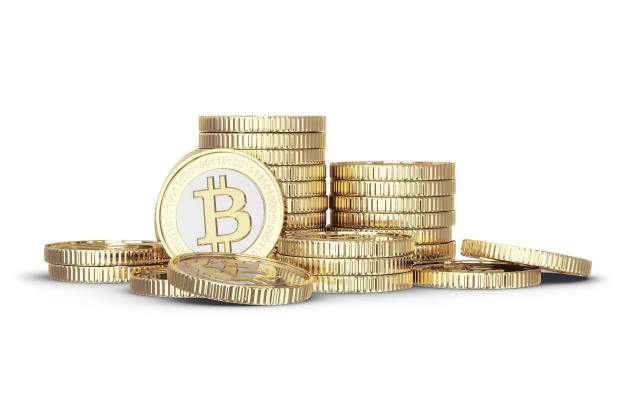

In [8]:
#portfolio_list_select = pn.widgets.MultiSelect(name='Portfolio', options=['bitcoin', 'ethereum', 'chainlink', 'polkadot', 'tellor'])
title1 = pn.pane.Markdown('# Crypto Analyzer', style={'font-family': "serif", "font-color":"navy"})
title2 = pn.pane.Markdown('# Summary of Returns and Market Cap', style={'font-family': "serif", "font-color":"navy"}) 
title3 = pn.pane.Markdown ('# Correlation Analysis?', style={'font-family': "serif", "font-color":"navy"})
title4 = pn.pane.Markdown ('# Risk Analysis', style={'font-family': "serif", "font-color":"navy"})
title5 = pn.pane.Markdown ('# Cumulative Returns', style={'font-family': "serif", "font-color":"navy"})
title6 = pn.pane.Markdown ('# Social Media Metrics', style={'font-family': "serif", "font-color":"navy"})
title7 = pn.pane.Markdown("# Findings and Conclusion", style={"font-family": "serif", "font-color":"navy"})
overview_column = pn.Column(title1,
    '**Project Background** - '
    'How Does Your Crypto Portfolio Compare '
    'to the Major Markets and Other Cryptocurrencies?',
    'Our research suggests it is possible to construct the necessary dataframe, '
    'function call, and visual experience that would allow a user to compare their '
    'cryptocurrency selections to major indices such as the S&P 500, Gold, and Bitcoin. ',
    '## Summary Analysis of Multiple Cryptocurrencies',
    portfolio_df_final,
    "https://freepngimg.com/thumb/bitcoin/59654-offering-exchange-"
    "initial-bitcoin-cryptocurrency-currency-digital.png",
    background='#F0F0F0', width=700, height=1000)

summary_column = pn.Column(title2,
    'How did my cryptocurrency portfolio perform in the last 24 hours compared to various assets?',
    price_market_cap_plot(portfolio_df),
    price_summary_violin(joined_price_df, title = 'Price Summary Analysis Over 5 Years for Various Assets (High/Low/Median)'),
    background="#f0f0f0", width=700, height=1000)

correlation_column = pn.Column(title3, 'This heatmap portrays the relationship between multiple asset types.',
    "What are the most correlated assets? The least correlated?",
    "",
    correlation_plot(joined_correlation_df, 
    title = 'Correlation Analysis of Multiple Assets with Cryptocurrencies'),
    "Most = Bitcoin and Chainlink", "Least = Bitcoin and Gold",
    background="#f0f0f0", width=700, height=1000)

risk_column = pn.Column(title4, "How strong is the Beta on an asset? Review the Sharpe ratio to determine "
    "if the asset has a strong performance relative to its risk.", 
    rolling_beta_plot(joined_beta_df, period=21, title = 'Rolling Beta Analysis of Multiple Assets with Cryptocurrencies'), 
    sharpe_ratios_plot(joined_sharpe_ratios, title = 'Sharpe Ratio Analysis of Multiple Assets with Cryptocurrencies'),
    std_plot(joined_std, title='Standard Deviation of Daily Returns'),
    background="#f0f0f0", width=700, height=1000)

cumulative_returns_column = pn.Column(title5, "Which of my assets had strongest cumulative return "
    "percentages amongst assets? Which had the highest sum of returns over time?", 
    cumulative_returns_plot(joined_cumulative_returns_df, title = "Cryptocurrencies vs Multiple Assets Cumulative Returns"),
    sum_return_plot(joined_cumulative_returns_df, title = "Sum of Cumulative Returns by CryptoCurrency vs Multiple Assets"),
    background="#f0f0f0", width=700, height=1000)

social_column = pn.Column(title6,"How hot is the topic of specific cryptocurrencies on "
    "social media? This analysis provides insight on trending cryptocurrencies.",
    social_plot(social_df, title = "Social Metrics for Multiple CryptoCurrencies"),
    background="#f0f0f0", width=700, height=500)

conclusion_column = pn.Column(title7,
    "•  A real-time cryptocurrency portfolio analysis is possible and worthwhile.",
    "•  We have the ability to measure performance.",
    "•  We know how crypto assets are correlated to each other and to other assets.",
    "•  The data provided unexpected results and proves the value of visualizations in the analysis process.",
    "",
    "**Although the complexity of evaluating this data was challenging due to the infancy of the crypto space, "
    "the overall results of the project were positive and encouraging.**",
    "https://freepngimg.com/thumb/bitcoin/59654-offering-exchange-"
    "initial-bitcoin-cryptocurrency-currency-digital.png",
    background="#F0F0F0", width=700, height=1000)


test_dashboard = pn.Tabs(
    ("Overview", overview_column),
    ("Market Cap & Summary Analysis", summary_column),
    ("Correlation", correlation_column),
    ("Risk", risk_column),
    ("Cumulative Returns",cumulative_returns_column),
    ("Social", social_column),
    ("Conclusion", conclusion_column),
    dynamic=True,
    tabs_location="above",
)

#test_dashboard_final = pn.Column(test_dashboard)
test_dashboard.servable()